In [138]:
# Pull phasing data
data_dir = 'data'
chromosome = '22'
family_ids, Xs, Ys, row_indices, col_indices = [], [], [], [], []
for filename in os.listdir(data_dir):
    if filename.endswith('%s.npz' % chromosome):
        data = np.load('%s/%s' % (data_dir, filename))
        if 'X' in data and 'Y' in data and 'row_indices' in data and 'col_indices' in data:
            family_ids.append(filename.split('.')[0])
            Xs.append(data['X'])
            Ys.append(data['Y'])
            row_indices.append(data['row_indices'])
            col_indices.append(data['col_indices'])

In [143]:
# Pull variants
variants = []
with open('v34.%s.txt' % chromosome, 'r') as f:
    for line in f:
        variants.append(int(line.strip()))
print(variants[:10], variants[-10:])

[16050007, 16050036, 16050102, 16050115, 16050116, 16050129, 16050137, 16050159, 16050199, 16050213] [51244381, 51244396, 51244420, 51244435, 51244437, 51244443, 51244509, 51244510, 51244515, 51244529]


In [144]:
m = 4*len(family_ids)
n = len(variants)

In [39]:
from scipy.sparse import coo_matrix
fullY = np.zeros((m, n), np.int8)

for i, Y in enumerate(Ys):
    fullY[(4*i):(4*(i+1)), col_indices[i]] = Y

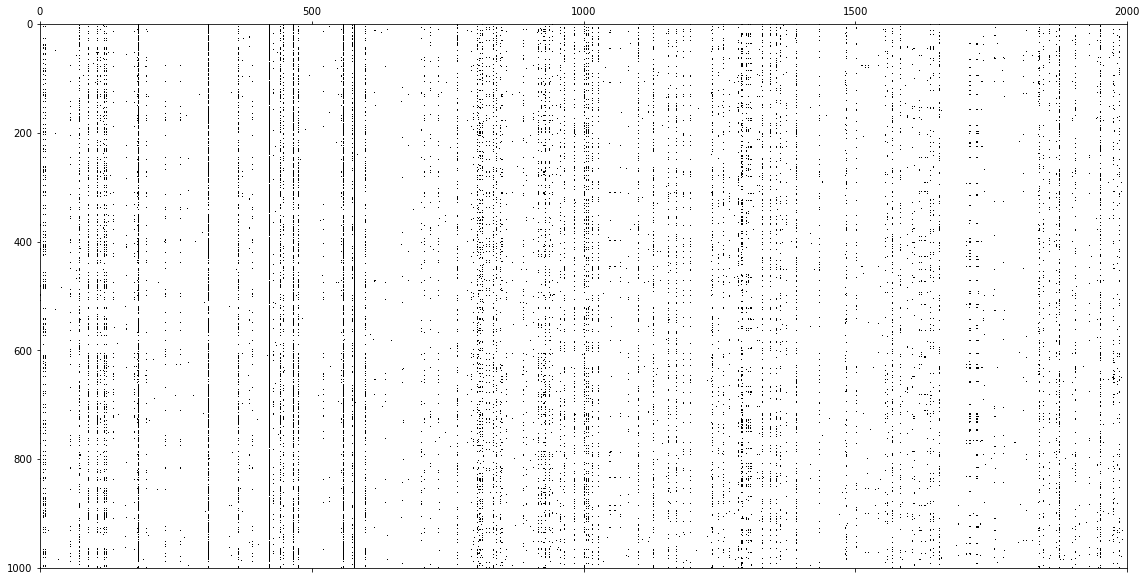

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.spy(fullY[:1000, :2000])
plt.show()

In [55]:

d = fullY[:, :1000].dot(fullY[:, :1000].T)

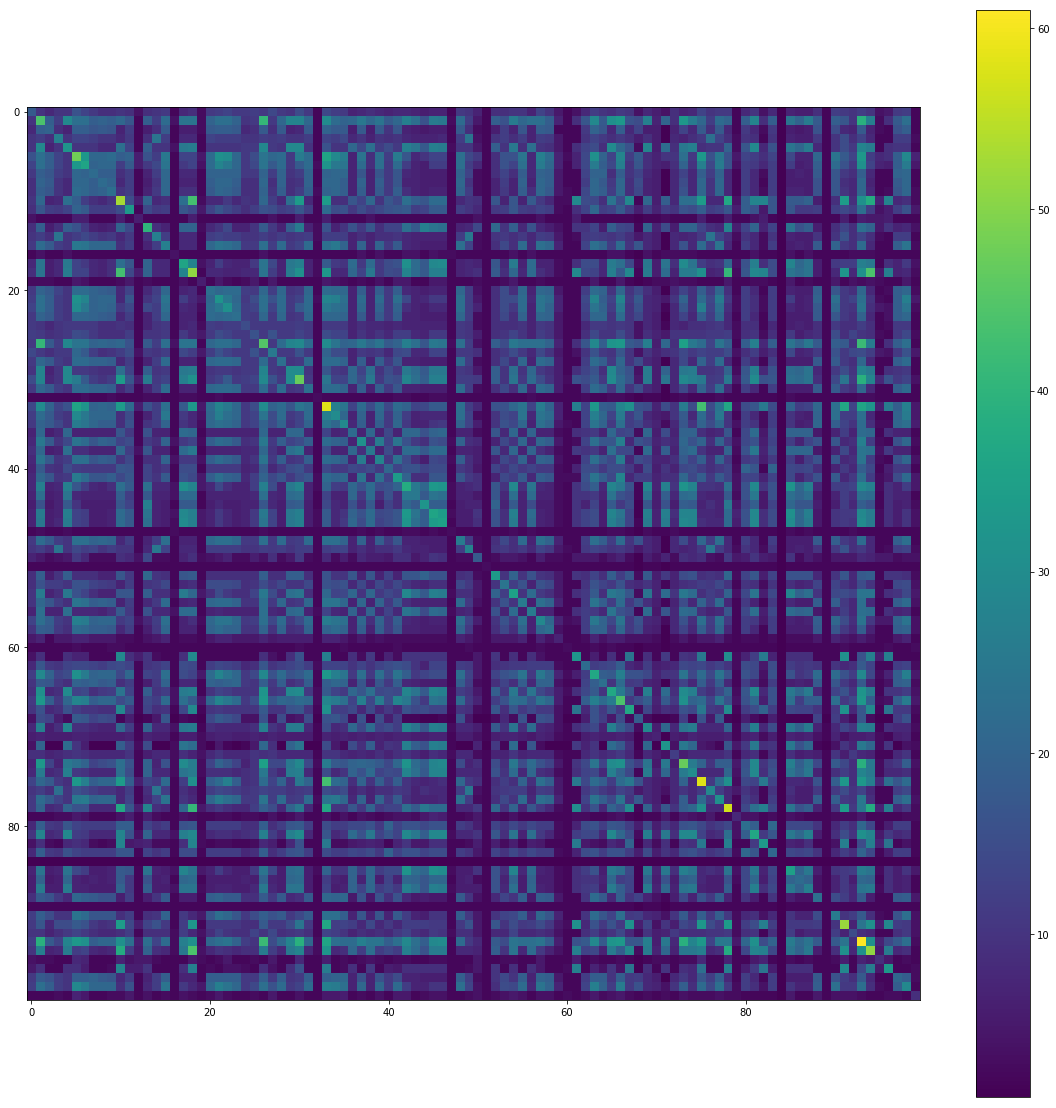

In [57]:
plt.figure(figsize=(20,20))
heatmap = plt.imshow(d[:100, :100])
plt.colorbar(heatmap)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

n = 10
for k, X in enumerate(Xs[:n]):
    if X is not None:
        m, _, _ = X.shape
        plt.subplot(n, 1, k+1)
        for i in range(2, m):
            plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
            plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
            plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
            plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')

        axes = plt.gca()
        axes.set_ylim([2,(m+1)*2])

plt.show()

In [66]:
maternal_recombinations = []
paternal_recombinations = []
for k, X in enumerate(Xs):
    if X is not None:
        m, _, n = X.shape
        for j in range(3, m):
            maternal_recombinations.extend([col_indices[k][i] for i in range(n-1) if X[j, 0, i] != X[j, 0, i+1]])
            paternal_recombinations.extend([col_indices[k][i] for i in range(n-1) if X[j, 2, i] != X[j, 2, i+1]])
            #print(maternal_recombinations, paternal_recombinations)

In [67]:
maternal_recombinations.sort()
paternal_recombinations.sort()
print(len(maternal_recombinations), len(paternal_recombinations))

3298 3093


In [104]:
chromosome = '21'
maternal_recombinations = []
paternal_recombinations = []
with open('recomb%s.txt' % chromosome, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] == 'M':
            maternal_recombinations.append(int(pieces[0]))
        else:
            paternal_recombinations.append(int(pieces[0]))
print(len(maternal_recombinations), len(paternal_recombinations))  
    

4597 4049


In [111]:
variants = []
with open('v34.%s.txt' % chromosome, 'r') as f:
    for line in f:
        variants.append(int(line.strip()))

In [112]:
# Pull recombination rate from Kong paper
# https://www.ncbi.nlm.nih.gov/pubmed/12053178?dopt=Abstract&holding=npg

rec = [0]*len(variants)
rec_female = [0]*len(variants)
rec_male = [0]*len(variants)
i = 0
with open('recombRate.txt') as f:
    for line in f:
        pieces = line.split('\t')
        chrom = pieces[0]
        start, end = [int(x) for x in pieces[1:3]]
        avg_rec, avg_rec_female, avg_rec_male = [float(x) for x in pieces[4:7]]
        
        if chrom == 'chr' + chromosome:
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                rec[i], rec_female[i], rec_male[i] = avg_rec, avg_rec_female, avg_rec_male
                i += 1
        

In [135]:
# Pull recombination rate from Bherer paper
# https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination

bins = range(0, len(variants), int(round(len(variants)/100)))
print(list(bins))

[0, 11536, 23072, 34608, 46144, 57680, 69216, 80752, 92288, 103824, 115360, 126896, 138432, 149968, 161504, 173040, 184576, 196112, 207648, 219184, 230720, 242256, 253792, 265328, 276864, 288400, 299936, 311472, 323008, 334544, 346080, 357616, 369152, 380688, 392224, 403760, 415296, 426832, 438368, 449904, 461440, 472976, 484512, 496048, 507584, 519120, 530656, 542192, 553728, 565264, 576800, 588336, 599872, 611408, 622944, 634480, 646016, 657552, 669088, 680624, 692160, 703696, 715232, 726768, 738304, 749840, 761376, 772912, 784448, 795984, 807520, 819056, 830592, 842128, 853664, 865200, 876736, 888272, 899808, 911344, 922880, 934416, 945952, 957488, 969024, 980560, 992096, 1003632, 1015168, 1026704, 1038240, 1049776, 1061312, 1072848, 1084384, 1095920, 1107456, 1118992, 1130528, 1142064, 1153600]


In [119]:
# Pull recombination rate from Bherer paper
# https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination

bins = range(0, n, int(round(n, 100)))
new_rec = [0]*len(variants)
new_rec_female = [0]*len(variants)
new_rec_male = [0]*len(variants)

start = None
i = 0
with open('Refined_genetic_map_b37/sexavg_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        end = int(pieces[1])
        avg_rec = float(pieces[2])
        if start is not None:
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                new_rec[i] = avg_rec
                i += 1
        start = end
        
start = None
i = 0
with open('Refined_genetic_map_b37/female_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        end = int(pieces[1])
        avg_rec = float(pieces[2])
        if start is not None:
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                new_rec_female[i] = avg_rec
                i += 1
        start = end
        
start = None
i = 0
with open('Refined_genetic_map_b37/male_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        end = int(pieces[1])
        avg_rec = float(pieces[2])
        if start is not None:
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                new_rec_male[i] = avg_rec
                i += 1
        start = end

N = 10000
new_rec = np.convolve(np.asarray(new_rec), np.ones((N,))/N, mode='same')
new_rec_female = np.convolve(np.asarray(new_rec_female), np.ones((N,))/N, mode='same')
new_rec_male = np.convolve(np.asarray(new_rec_male), np.ones((N,))/N, mode='same')

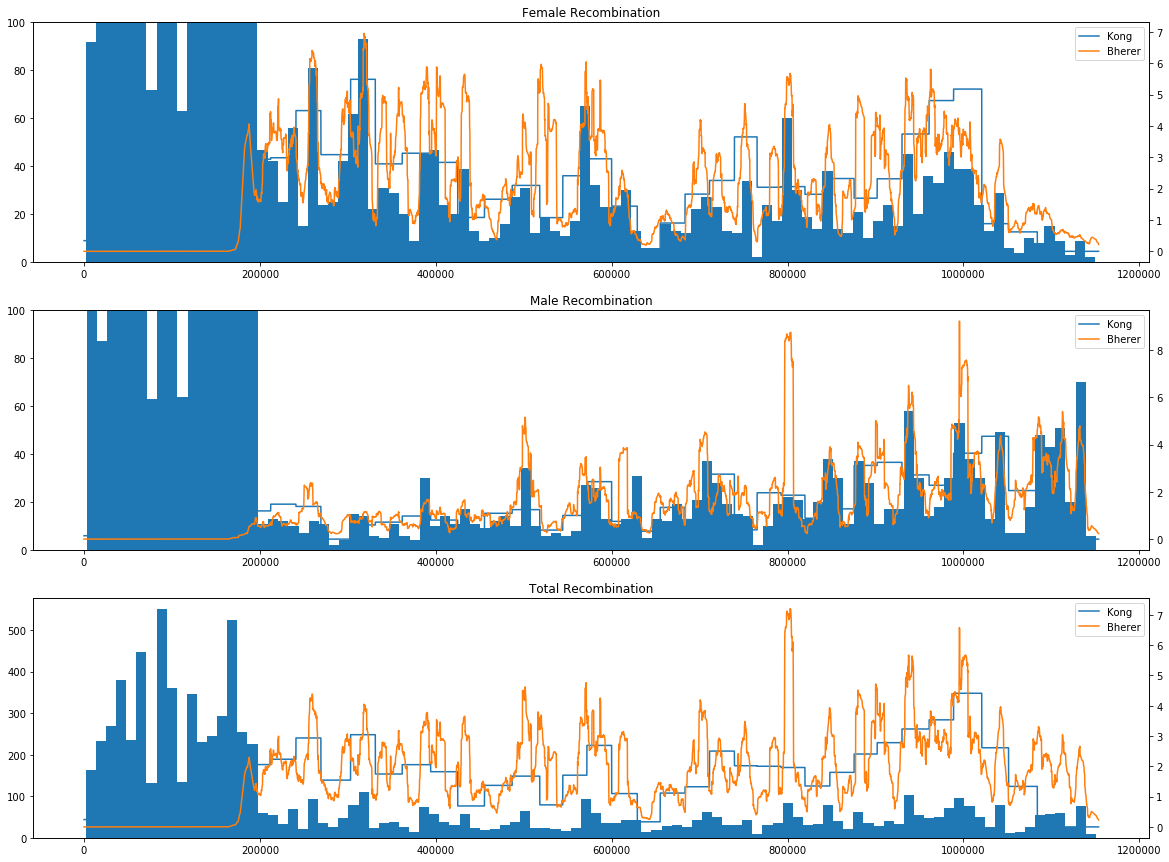

In [121]:
plt.figure(figsize=(20,15))
ax1 = plt.subplot(3, 1, 1)
ax1.hist(maternal_recombinations, bins=100)
ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(rec_female, label='Kong')
ax2.plot(new_rec_female, label='Bherer')
#ax2.set_ylim([0, 10])
plt.legend()
plt.title('Female Recombination')

ax1 = plt.subplot(3, 1, 2)
ax1.hist(paternal_recombinations, bins=100)
ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(rec_male, label='Kong')
ax2.plot(new_rec_male, label='Bherer')
#ax2.set_ylim([0, 10])
plt.legend()
plt.title('Male Recombination')

both_recombinations = maternal_recombinations + paternal_recombinations
both_recombinations.sort()
ax1 = plt.subplot(3, 1, 3)
ax1.hist(both_recombinations, bins=100)
#ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec, label='Kong')
ax2.plot(new_rec, label='Bherer')
#ax2.set_ylim([0, 10])
plt.legend()
plt.title('Total Recombination')

plt.show()

4597
1153633
101


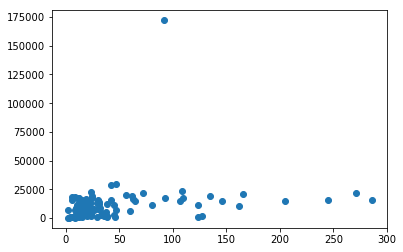

In [132]:
print(len(maternal_recombinations))
print(len(new_rec_female))
hist, bin_edges = np.histogram(maternal_recombinations, bins=100)
print(len(bin_edges))
plt.scatter(hist, rec_hist)
plt.show()